Below the date correponding to each attack, in order to select a particular .csv (avoid loading **HUGE** file)
```
Benign ['01/03/2018' '16/02/2018' '02/03/2018' '23/02/2018' '15/02/2018'
 '28/02/2018' '22/02/2018' '10/01/1970' '11/01/1970' '12/01/1970'
 '21/02/2018' '14/02/2018' '05/01/1970' '08/01/1970' '20/02/2018']
DDOS attack-HOIC ['21/02/2018']
DDoS attacks-LOIC-HTTP ['20/02/2018']
DoS attacks-Hulk ['16/02/2018']
Bot ['02/03/2018']
FTP-BruteForce ['14/02/2018']
SSH-Bruteforce ['14/02/2018']
Infilteration ['01/03/2018' '28/02/2018']
DoS attacks-SlowHTTPTest ['16/02/2018']
DoS attacks-GoldenEye ['15/02/2018']
DoS attacks-Slowloris ['15/02/2018']
DDOS attack-LOIC-UDP ['21/02/2018']
Brute Force -Web ['23/02/2018' '22/02/2018']
Brute Force -XSS ['23/02/2018' '22/02/2018']
SQL Injection ['23/02/2018' '22/02/2018']
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc,confusion_matrix, plot_confusion_matrix,roc_auc_score
from sklearn.utils import class_weight
import glob

RANDOM_STATE_SEED = 77

In [2]:
# read the whole dataset just by leaving .csv 
all_files  = glob.glob("../DDOS/dataset/*20-02-2018*.csv") #selecte only DDOS attack on 20/02/2018
print(all_files)

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# display data
df

['../DDOS/dataset/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv']


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.31.69.25-94.231.103.172-22-45498-6,94.231.103.172,45498,172.31.69.25,22,6,20/02/2018 08:34:07,888751,11,11,...,32,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,20/02/2018 08:33:22,112642816,3,0,...,0,0.0,0.0,0.0,0.0,56300000.0,7.071068,56300000.0,56300000.0,Benign
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,20/02/2018 08:36:11,112642712,3,0,...,0,0.0,0.0,0.0,0.0,56300000.0,18.384776,56300000.0,56300000.0,Benign
3,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,20/02/2018 08:39:00,112642648,3,0,...,0,0.0,0.0,0.0,0.0,56300000.0,5.656854,56300000.0,56300000.0,Benign
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,20/02/2018 08:41:49,112642702,3,0,...,0,0.0,0.0,0.0,0.0,56300000.0,65.053824,56300000.0,56300000.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7948743,172.31.69.7-185.2.197.19-623-42801-6,185.2.197.19,42801,172.31.69.7,623,6,20/02/2018 01:41:45,94042,2,1,...,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
7948744,172.31.69.7-195.22.125.42-22-2178-6,195.22.125.42,2178,172.31.69.7,22,6,20/02/2018 11:51:06,251281,4,2,...,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
7948745,172.31.69.7-107.3.188.61-23-14259-6,107.3.188.61,14259,172.31.69.7,23,6,20/02/2018 08:49:20,21,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
7948746,172.31.69.7-5.188.11.188-3039-54193-6,5.188.11.188,54193,172.31.69.7,3039,6,20/02/2018 02:00:54,181954,2,1,...,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


In [3]:
def cleanDataset(df):
    
    print('Initial size was ', df.shape)
    # replace +ve and -ve infinity with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # drop missing values
    print('Now drop missing values')
    df.dropna(inplace=True)
    
    print('Dataset cleaned. Now shape is', df.shape)
    
cleanDataset(df)

Initial size was  (7948748, 84)
Now drop missing values
Dataset cleaned. Now shape is (7889295, 84)


In [4]:
df["Label"].value_counts()

Benign                    7313104
DDoS attacks-LOIC-HTTP     576191
Name: Label, dtype: int64

We just group under label "Malware" all type of attacks (some files contains different kind of attack)

In [5]:
listMalware = [label for label in df["Label"].value_counts().keys() if not 'Benign' in label ]
print(listMalware)
df.replace(to_replace=listMalware, value="Malware", inplace=True)

['DDoS attacks-LOIC-HTTP']


<AxesSubplot:title={'center':'Event Label'}>

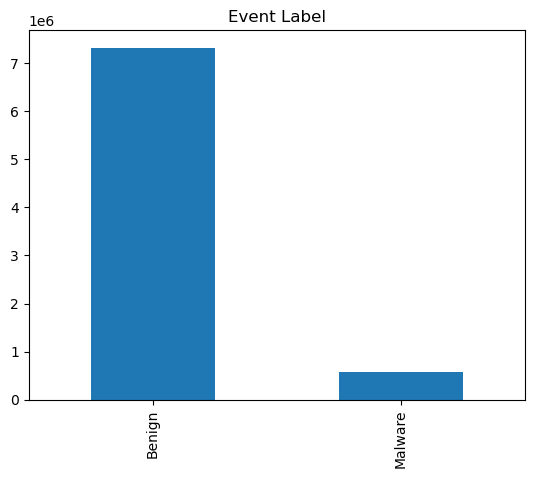

In [6]:
df["Label"].value_counts().plot(kind='bar',
                               y='Events',
                               title='Event Label'
                               )

## DNN approach


Let's create a dataset with the same label distribution

In [7]:
nSize = df[df["Label"] == "Malware"].shape[0]
print(nSize)
df1 = df[df["Label"] == "Benign"][:nSize]
df2 = df[df["Label"] == "Malware"][:nSize]
df_final = pd.concat([ df1,df2], axis =0)

#We now encode our class labels to integer values for the model to use.

df_final.replace(to_replace="Benign", value=0, inplace=True)
df_final.replace(to_replace="Malware", value=1, inplace=True)

576191


In [8]:
train, test = train_test_split(df_final, test_size=0.3, random_state=RANDOM_STATE_SEED)

Get list of non numerical columns

In [9]:
objectColumns = list(df.select_dtypes(['object']).columns)
objectColumns.remove("Label")

print('Non numerical features (Skipping Label)', objectColumns)

numericColumns = df.select_dtypes(include=[np.number]).columns.to_list()

print(numericColumns)

print( 1 + len(numericColumns) + len(objectColumns), df.shape[1])

Non numerical features (Skipping Label) ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']
['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',

Standardization: normalize all features

In [10]:
min_max_scaler = MinMaxScaler().fit(train[numericColumns])


In [11]:
train[numericColumns] = min_max_scaler.transform(train[numericColumns])
test[numericColumns] = min_max_scaler.transform(test[numericColumns])

In [12]:
print("Full dataset:\n")
print("Benign: " + str(df_final["Label"].value_counts()[[0]].sum()))
print("Malware: " + str(df_final["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malware: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malware: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 576191
Malware: 576191
---------------
Training set:

Benign: 403051
Malware: 403616
---------------
Test set:

Benign: 173140
Malware: 172575


In [13]:

#remove object columns
train.drop(objectColumns, axis=1,inplace=True)
test.drop(objectColumns,axis=1,inplace=True)



In [14]:
#X after y, since we're slicing "Label" columns
y_train = np.array(train.pop("Label"))
X_train = train.values



y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
X_test = test.values


print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(806667, 79)
(806667,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(345715, 79)
(345715,)


## NN with Keras

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks



2022-11-08 17:31:54.826127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 17:31:54.990931: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 17:31:55.649614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 17:31:55.649693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [16]:
def define_model(initial_input_shape):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(initial_input_shape,)),
       
       
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate = 0.25),
        layers.Dense(64, activation='relu'),
        layers.Dropout(rate = 0.25),
        layers.Dense(32, activation='relu'),
        layers.Dropout(rate = 0.25),
        layers.Dense(1, activation='sigmoid'),
    ])
    optimizer = tf.keras.optimizers.Adam(epsilon=0.01)


    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    model.summary()
    return model

Create model

In [17]:
dnn = define_model(X_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               10240     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

2022-11-08 17:31:57.248223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 17:31:58.065357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30975 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:21:00.0, compute capability: 7.0
2022-11-08 17:31:58.066417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30975 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0


Train model

In [18]:
early_stopping = callbacks.EarlyStopping(
        min_delta = 1e-4,
        patience = 10,
        restore_best_weights = True
    )
history = dnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size = 256,
    validation_split=0.25,
    callbacks=[early_stopping]
)

Epoch 1/50
2364/2364 [==============================] - 6s 2ms/step - loss: 0.1112 - binary_accuracy: 0.9608 - val_loss: 0.0185 - val_binary_accuracy: 0.9956
Epoch 2/50
2364/2364 [==============================] - 6s 2ms/step - loss: 0.0174 - binary_accuracy: 0.9949 - val_loss: 0.0099 - val_binary_accuracy: 0.9965
Epoch 3/50
2364/2364 [==============================] - 5s 2ms/step - loss: 0.0111 - binary_accuracy: 0.9967 - val_loss: 0.0066 - val_binary_accuracy: 0.9973
Epoch 4/50
2364/2364 [==============================] - 6s 2ms/step - loss: 0.0079 - binary_accuracy: 0.9976 - val_loss: 0.0043 - val_binary_accuracy: 0.9985
Epoch 5/50
2364/2364 [==============================] - 5s 2ms/step - loss: 0.0060 - binary_accuracy: 0.9983 - val_loss: 0.0037 - val_binary_accuracy: 0.9986
Epoch 6/50
2364/2364 [==============================] - 5s 2ms/step - loss: 0.0047 - binary_accuracy: 0.9987 - val_loss: 0.0030 - val_binary_accuracy: 0.9991
Epoch 7/50
2364/2364 [==============================

## Evaluating metrics

Plotting loss and accuracy

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


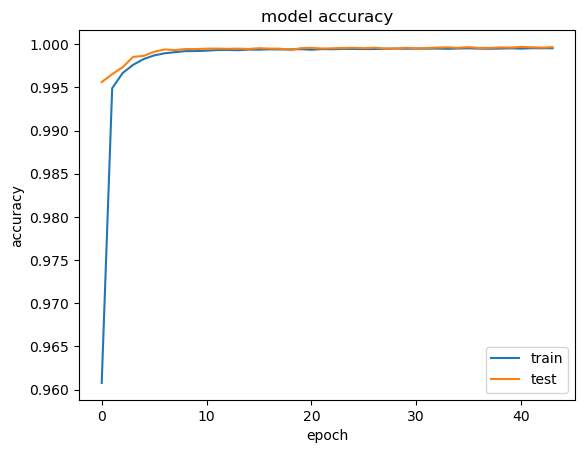

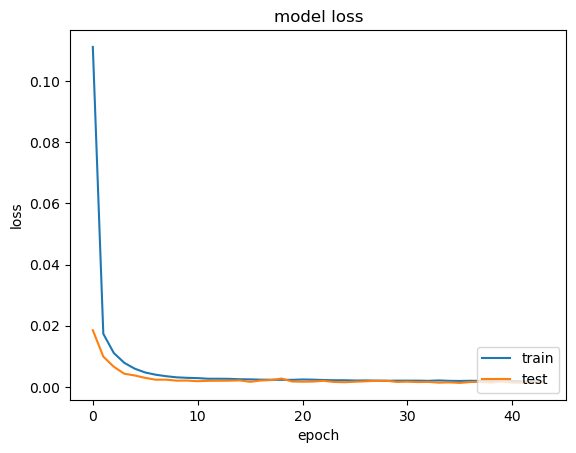

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Evaluating model and predictions

In [20]:
scores = dnn.evaluate(X_test, y_test )
print("\n%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))

10804/10804 [==============================] - 13s 1ms/step - loss: 0.0010 - binary_accuracy: 0.9997

binary_accuracy: 99.97%


In [21]:
predictions=(dnn.predict(X_test) > 0.5).astype("int32")
pred=(dnn.predict(X_test))

10804/10804 [==============================] - 8s 701us/step


In [22]:
print(predictions.shape, pred.shape)
print(np.array_equal(pred, predictions))

(345715, 1) (345715, 1)
False


In [23]:
print(accuracy_score(y_test, predictions))

0.9997049592872742


<AxesSubplot:>

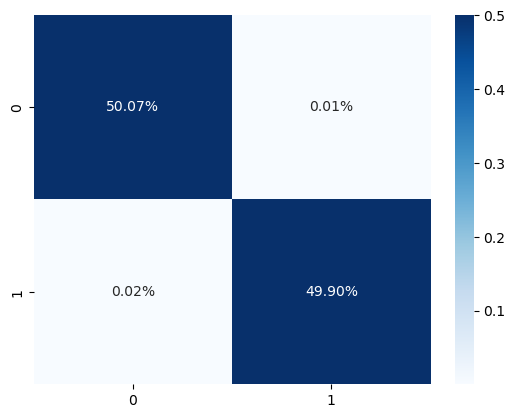

In [24]:
cf_matrix = confusion_matrix(y_test, predictions)
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [25]:
roc_auc_score(y_test, predictions,  average='micro')

0.999704911226243

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, predictions)
plt.plot(fpr,tpr,label=' auc = %.1f%%'%(auc(fpr,tpr)*100.))